# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

# Imports

Die Config wurde ausgelagert, da _Transfer Learning_ ähnliche Bedingungen benötigt.  


In [2]:
import tensorflow as tf
import keras
import numpy as np
import os
from pathlib import Path
import numpy as np
import sys
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from utils.setup import setup_dataset, generateDatasetArrays
from helper.visualize import visualize_history, visualize_predictions, getDognames

# load configuration
import config as Config
random.seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
tf.random.set_seed(Config.RANDOM_SEED)

2024-12-18 00:05:03.589679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734476703.600338  825199 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734476703.603544  825199 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 00:05:03.615114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Laden der Daten und Splitting in Trainings- und Testdaten (Aufgabe 1)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_, _Deep Learning_ und _Transfer Learning_ und wurde somit in `setup.py` ausgelagert.

Es werden alle Hunde aus dem Datensatz entfernt, die nicht eine der Label IDs in `Config.DOG_LABEL_IDS` haben. Danach wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.    

Bei der Hundeauswahl wurde darauf geachtet, dass die Merkmale, wie Farbe, Größe, Haare usw. sich stark unterscheiden um somit die Varianz zu erhöhen. 

I0000 00:00:1734476706.833361  825199 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6
2024-12-18 00:05:06.936639: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-18 00:05:08.070859: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Image count:  500


2024-12-18 00:05:08.913828: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Dataset Size: 375
Test Dataset Size: 125


2024-12-18 00:05:10.116648: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


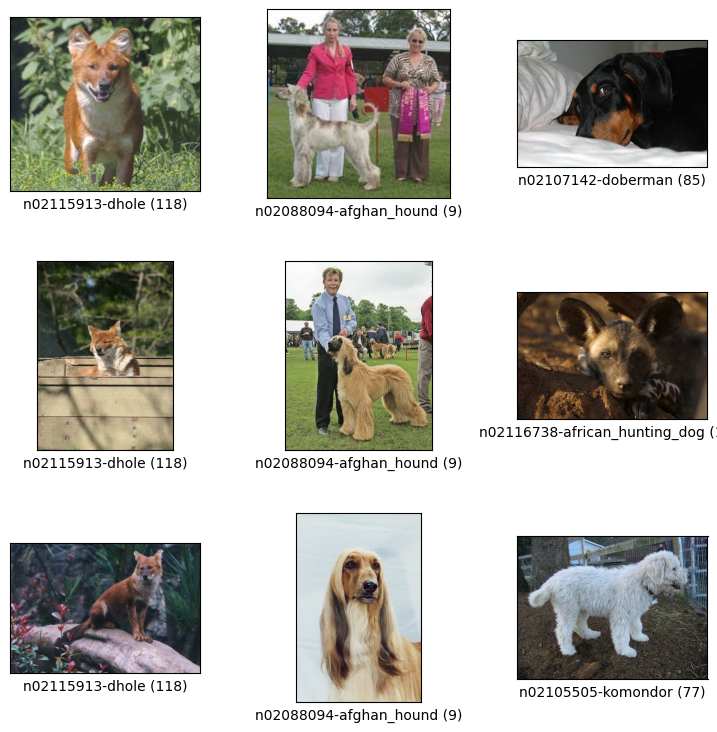

/home/jakob/Documents/git/ml-lecture/utils/setup.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


image  \
0  [[[26, 25, 30], [25, 24, 29], [24, 23, 28], [2...   
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
2  [[[153, 158, 151], [150, 155, 148], [154, 159,...   
3  [[[37, 46, 29], [36, 45, 28], [35, 44, 27], [3...   

                                      image/filename  label  \
0       b'Images/n02115913-dhole/n02115913_3998.jpg'    118   
1  b'Images/n02088094-Afghan_hound/n02088094_4049...      9   
2     b'Images/n02107142-Doberman/n02107142_971.jpg'     85   
3       b'Images/n02115913-dhole/n02115913_2895.jpg'    118   

                               objects/bbox  
0  [[0.07084469, 0.28, 0.98092645, 0.6975]]  
1    [[0.38647342, 0.005, 0.9661836, 0.64]]  
2   [[0.08108108, 0.206, 0.8798799, 0.992]]  
3    [[0.32, 0.23888889, 0.61, 0.75277776]]
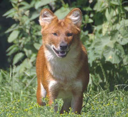
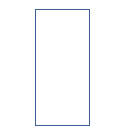
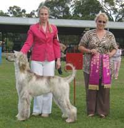
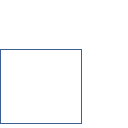
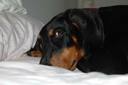
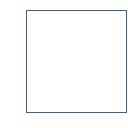
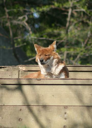
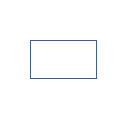

In [3]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS, show_examples=True)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["label"] = label_lookup_table.lookup(data["label"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    return data

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

# CNN Model erstellen (Aufgabe 2 und 3)

Hier wird eine sequentielle Netzwerkarchitektur für die Aufgabe der Klassifizierung gewählt.

Die Merksmalextrahierung wird durch 3 gleich aufgebaute Blöcke erzielt.

Beginnend mit einem **Convolutional Layer** (Faltungsschicht). Diese Schicht ist für die Merkmalsextraktion verantwortlich und suchen nach Mustern in den Eingabebildern, wie z.B. Kanten, Texturen oder Formen. Es wird eine Kernelgröße von 3x3 gewählt, da sie eine gute Balance zwischen Rechenaufwand und Extraktion von Mustern bietet. \
**BatchNormalization**: Diese Schicht hilft, die Trainingseffizienz zu erhöhen, indem sie die Aktivierungen jeder Schicht normalisiert und somit die interne Covariate Shift reduziert. Dies führt in der Regel zu einer stabileren und schnelleren Konvergenz. \
**MaxPooling2D**: Max-Pooling reduziert die räumliche Dimension der Feature Maps und hilft dabei, Rechenressourcen zu sparen, indem es die Bildgrößen verkleinert. Gleichzeitig werden nur die wichtigsten Merkmale beibehalten, was zur Vermeidung von Überanpassung (Overfitting) beiträgt. \
**Dropout**: Dropout wird eingesetzt, um Überanpassung zu verhindern, indem es während des Trainings zufällig eine bestimmte Anzahl von Neuronen löscht. In diesem Modell beträgt die Dropout-Rate 0.25 in den ersten beiden Blocks und 0.5 nach der Flatten-Schicht. Höhere Dropout-Raten nach der Flatten-Schicht verhindern, dass das Modell zu stark auf den Trainingsdaten anpasst und dadurch schlechtere Generalisierung auf unbekannte Daten aufweist.

```py
keras.layers.Conv2D(128, (3, 3), activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Dropout(0.25),
```


## Wahl einer geeigneten Lossfunktion und eines Optimizers (Aufgabe 4)
**Loss-Funktion:** SparseCategoricalCrossentropy <br>
Die Wahl der Loss-Funktion ist für die Trainingsdynamik und das endgültige Modell von entscheidender Bedeutung. In diesem Fall wird die SparseCategoricalCrossentropy verwendet. Diese Funktion ist besonders gut geeignet für Multiklassen-Klassifikationsprobleme, bei denen das Ziel darin besteht, ein Bild einer von mehreren möglichen Kategorien zuzuordnen.

Im Gegensatz zu der CategoricalCrossentropy-Loss-Funktion, die One-Hot-Encoded Labels erwartet, kann SparseCategoricalCrossentropy direkt mit integer-kodierten Labels arbeiten, d.h., anstelle einer Vektordarstellung (z.B. [0, 1, 0] für Klasse 1) wird eine einfache Zahl (z.B. 1) als Label genutzt. Dies spart Speicherplatz und Rechenressourcen und ist daher eine gute Wahl, wenn die Labels als ganze Zahlen vorliegen. (Definiert in den Annotations xml Files)

Die cross-entropy misst den Unterschied zwischen der tatsächlichen Verteilung der Daten und der vom Modell vorhergesagten Verteilung. In diesem Fall wird der Fehler über alle Klassen hinweg berechnet, wobei die größte Vorhersagewahrscheinlichkeit für die richtige Klasse zu einem niedrigeren Verlust führt.

**Optimizer:** Adam <br>
Der Adam (Adaptive Moment Estimation)-Optimizer wurde gewählt, da er eine adaptive Lernratenstrategie verwendet, die den Lernfortschritt stabiler macht. Ein wichtiger Vorteil von Adam gegenüber klassischen Optimierern wie Stochastic Gradient Descent (SGD) ist, dass er automatisch die Lernrate für jedes Gewicht im Modell anpasst, was zu schnelleren und stabileren Ergebnissen führt.

Es wurde auch mit SGD experimentiert, aber wie im Text erwähnt, führten diese Versuche zu schlechteren Ergebnissen. Das ist oft der Fall, weil SGD die Lernrate konstant hält oder manuell anpassen muss, was das Training schwieriger machen kann, vor allem bei komplexen Modellen.

Somit haben wir uns schlussendlich für _Adam_ entschieden.

In [3]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(*Config.RESIZE_SIZE, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(Config.NUM_CLASSES, activation='softmax')
])


model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 58, 58, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,801,157 (106.05 MB)

 Trainable params: 27,800,709 (106.05 MB)

 Non-trainable params: 448 (1.75 KB)

## Training des Models (Aufgabe 5)

Das Modell wird mit einer 3-fachen Stratified Kreuzvalidierung trainiert, um die Generalisierungsfähigkeit zu bewerten und Überanpassung zu vermeiden.
Hierfür wird der **Trainingsdatensatz** in drei gleichgroße Teile unterteilt. Bei jedem durchlauf werden nun zwei der drei Datenteile für das Training genutzt und der letzte als "Testdatensatz" (Der echte Testdatensatz (25%) darf nicht für das training verwendet werden).

Da die Funktion `kf.split` Numpy-Arrays erwartet, werden die tf.data.Dataset-Daten in Arrays umgewandelt. In jedem Fold wird das Modell auf den Trainingsdaten trainiert und anhand der Validierungsdaten überprüft. Die Ergebnisse (Loss, Genauigkeit) werden über alle Folds gemittelt, um eine robuste Leistungseinschätzung zu erhalten.

Die Testdaten dienen zur finalen Bewertung des Modells. Das Modell wurde an diese Bilder nicht angelernt wodurch _overfitting_ erkennbar werden kann.
Der Klassifizierungsberichte und die Konfusionsmatrizen visualisieren die Vorhersagequalität des Modells.

---
**Bewertung des Ergebnisses** \
Die Trainingsaccuracy (train_dataset) beträgt im Durchschnitt _0.560_ und weicht somit stark von der im Graphen gezeigten Validationaccuracy während des Trainings ab (0.78). Das ist darauf zurück zu führen, dass die Daten bei dem Training aus dem Trainingsdatensatz stammen. (3-fold oben erklärt)
Auf der Konfusionsmatrix ist gut zu erkennen, welche Hunde falsch erkannt wurden und mit welcher Rasse sie verwechselt wurden. Zum Beispiel wurde der Afghan Hound kein einziges mal fälschlicherweise als dhole oder Doberman klassifiziert.

2024-12-17 23:03:54.558804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fold 1 am Laufen


I0000 00:00:1734473037.683806  808659 service.cc:148] XLA service 0x7fe304013c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734473037.683824  808659 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-17 23:03:57.720649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734473037.906750  808659 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734473050.150873  808659 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Fold 2 am Laufen
Fold 3 am Laufen
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step

Klassifizierungsbericht (Gesamtergebnis aus allen Folds):

                     precision    recall  f1-score   support

           komondor       0.62      0.56      0.59        27
African_hunting_dog       0.60      0.78      0.68        27
       Afghan_hound       0.67      0.36      0.47        22
           Doberman       0.57      0.57      0.57        23
              dhole       0.42      0.50      0.46        26

           accuracy                           0.56       125
          macro avg       0.58      0.55      0.55       125
       weighted avg       0.57      0.56      0.56       125

Konfusionsmatrix:


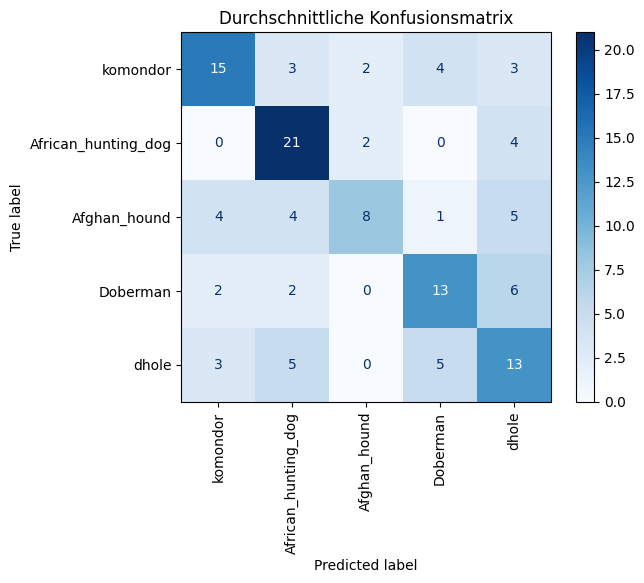

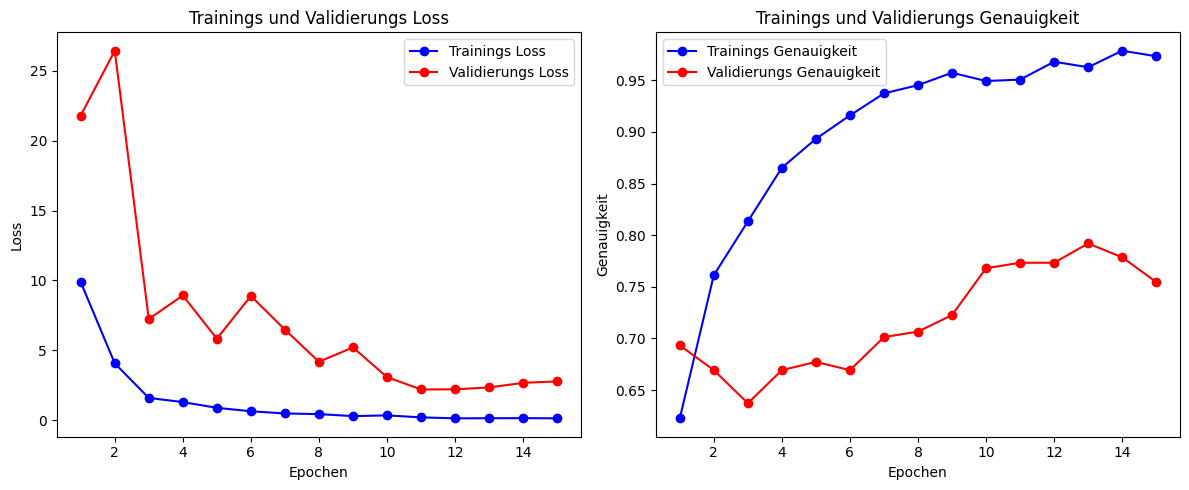

Test accuracy: 0.560


In [4]:
# Kreuzvalidierung (3-fold)
kf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=Config.RANDOM_SEED
)

"""
It somehow is simpler using numpy arrays instead of tf.data.Dataset for fitting the model.

So we will convert the tf.data.Dataset to numpy arrays.
"""
images, labels = generateDatasetArrays(train_dataset)
images_test, labels_test = generateDatasetArrays(test_dataset)

history = []
fold = 1

for train_indexes, val_indexes in kf.split(images, labels):
    print(f"Fold {fold} am Laufen")
    images_train_fold, images_val_fold = images[train_indexes], images[val_indexes]
    labels_train_fold, labels_val_fold = labels[train_indexes], labels[val_indexes]
    
    fold_history = model.fit(
        images_train_fold,
        labels_train_fold,
        validation_data=(images_val_fold, labels_val_fold),
        epochs=Config.EPOCHS,
        batch_size=Config.BATCH_SIZE,
        verbose=1 if Config.DEBUG else 0
    )
    history.append(fold_history.history)

    fold += 1

class_labels = list(getDognames(train_dataset).values())
# Evaluation
y_pred = model.predict(images_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nKlassifizierungsbericht (Gesamtergebnis aus allen Folds):\n")
print(classification_report(labels_test, y_pred_classes, target_names=class_labels))

# Visualisierung der Konfusionsmatrix
print("Konfusionsmatrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_test, y_pred_classes), display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()

avg_history = {
    'loss': np.mean([h['loss'] for h in history], axis=0),
    'accuracy': np.mean([h['accuracy'] for h in history], axis=0),
    'val_loss': np.mean([h['val_loss'] for h in history], axis=0),
    'val_accuracy': np.mean([h['val_accuracy'] for h in history], axis=0)
}

# Visualize the history
visualize_history(avg_history)

loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc)

# Save the model
model.save_weights(os.path.join(Config.MODEL_FOLDER, Config.WEIGHTS_FILENAME))
model.save(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

# Tests des Modells (Aufgabe 5 Teil 2)
#### Zusammenfassung & Ausblick
Zusammengefasst zeigt das CNN-Modell solide Leistungen bei der Klassifikation der fünf Hunderassen mit einer durchschnittlichen Genauigkeit von 0,58 (58%), was deutlich über zufälligem Raten (20%) liegt, womit das Trainieren des Modells als Erfolg gewertet werden kann.

---

In der letzen Sektion _Training des Models_ wurde bereits das Model mit dem Testdatensatz getestet.
Hier werden ein paar zufällige Bilder aus dem Datensatz Klassifiziert und das Ergebnis visuell dargestellt.

2024-12-18 00:06:10.515403: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 110231552 exceeds 10% of free system memory.
2024-12-18 00:06:10.692174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 110231552 exceeds 10% of free system memory.
2024-12-18 00:06:14.234281: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1734476774.401391  895911 service.cc:148] XLA service 0x7f11ac0049e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734476774.401412  895911 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-18 00:06:14.407401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734476774.438943  895911 cuda_dnn.cc:529] Loa

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


I0000 00:00:1734476774.985276  895911 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


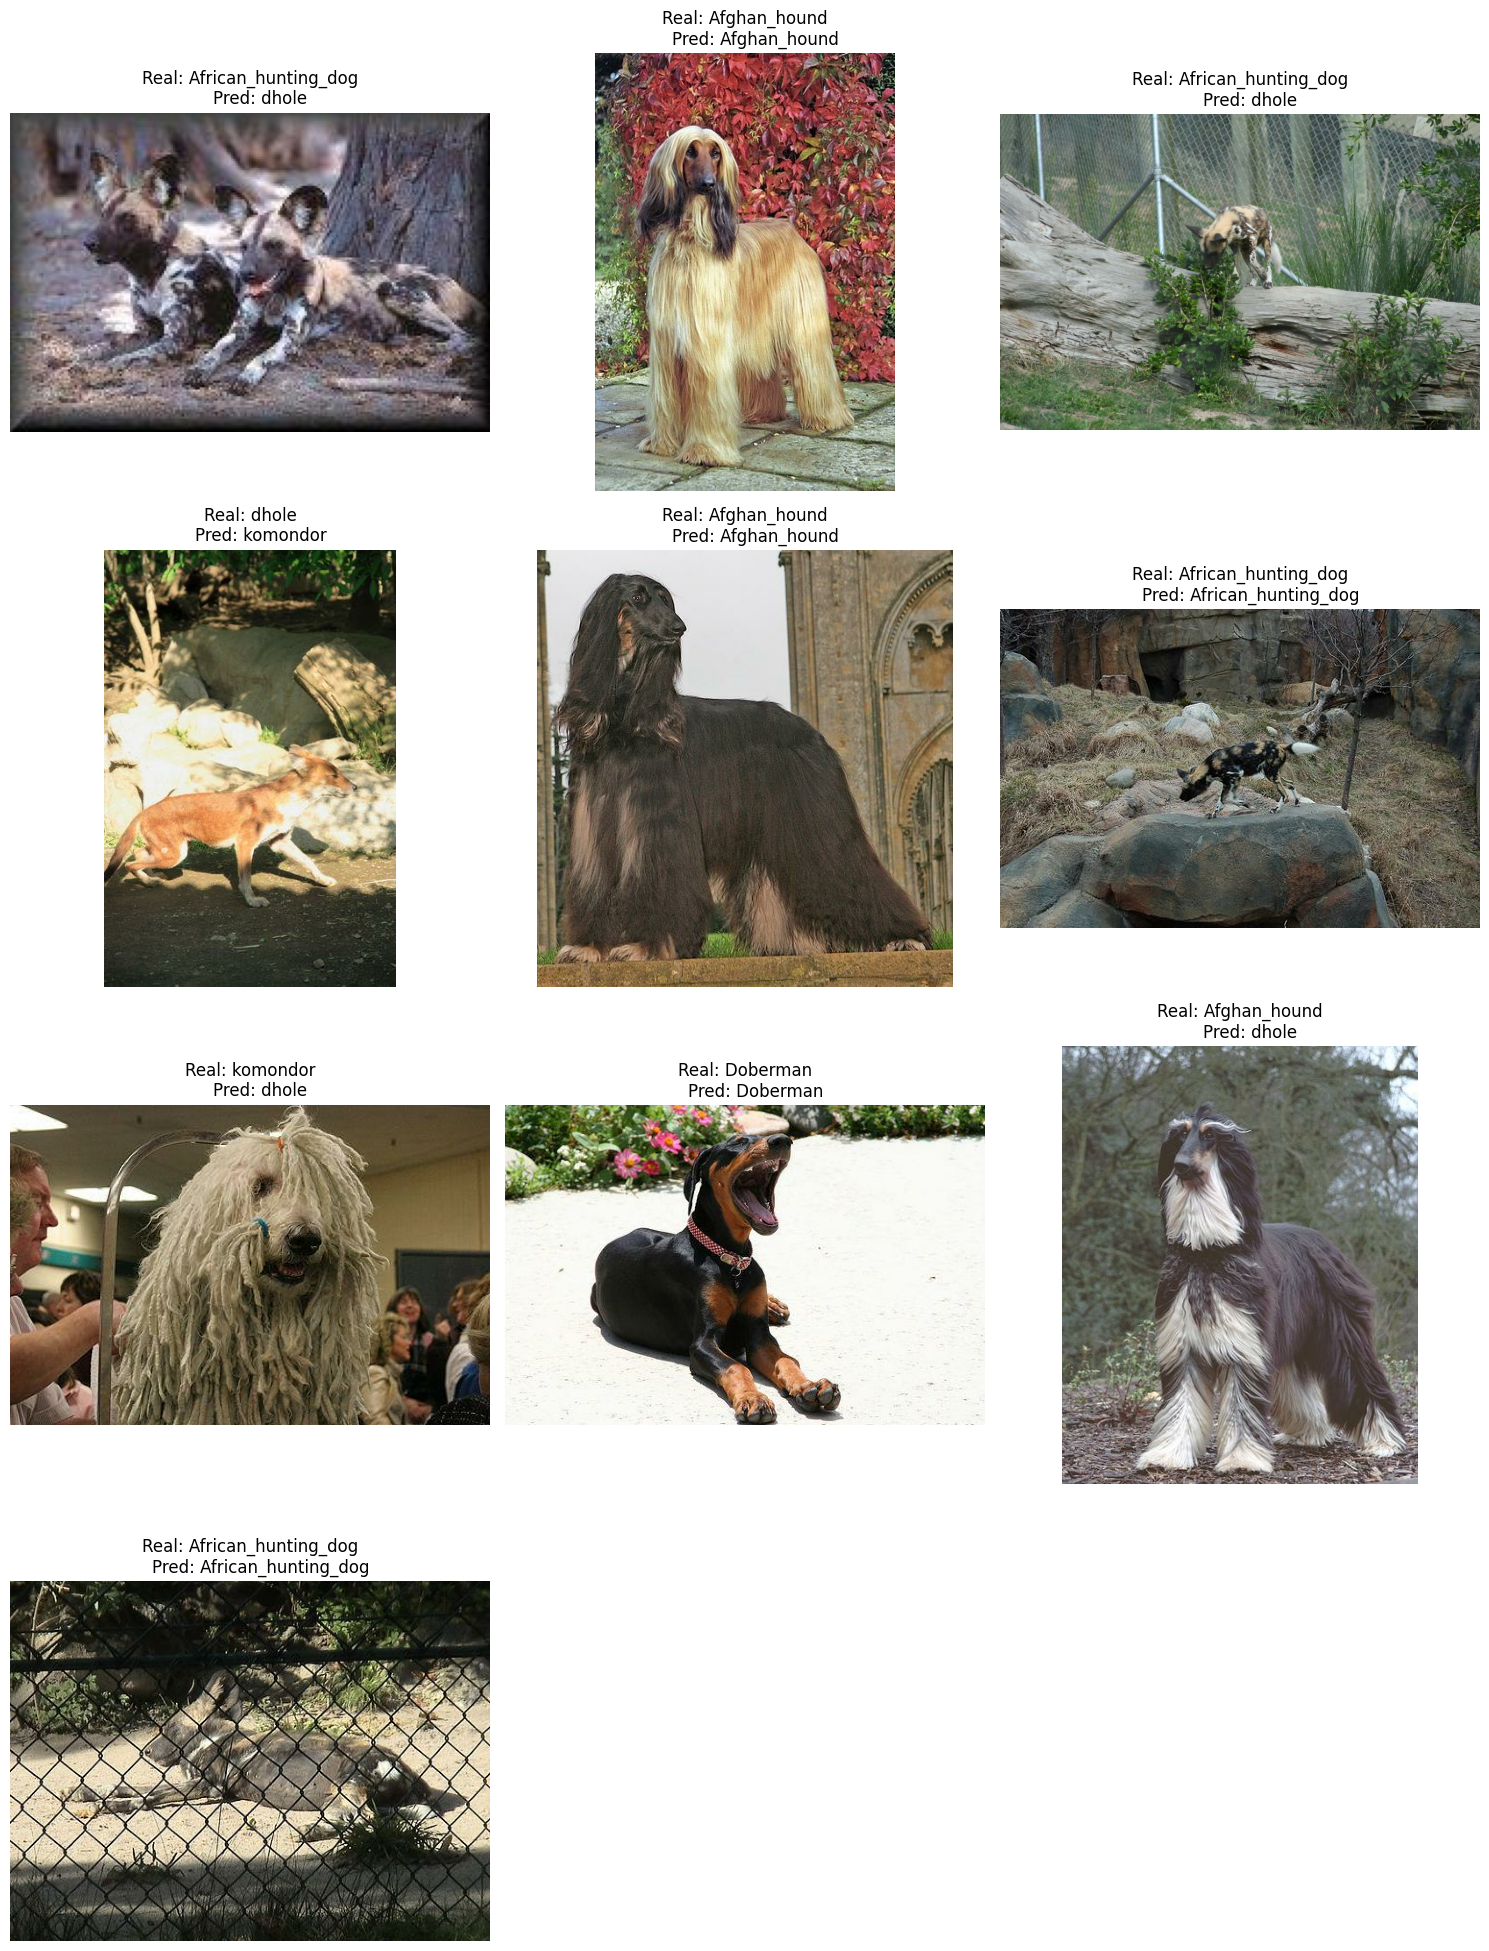

In [6]:
visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME),
    test_dataset
)